SRAG 2021 e 2022 - Banco de Dados de Síndrome Respiratória Aguda Grave - incluindo dados da COVID-19

Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import io
import requests
from sklearn.feature_selection import chi2
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sn
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
import warnings
from PIL import Image

Datasets

In [3]:
df_original = pd.read_csv('df_preprocessed.csv', delimiter=',')

In [4]:
df = df_original.copy(deep = True)
df.drop(columns=['Unnamed: 0'], inplace= True)

CONSTANTS

Pre processing

1. Table 3: Risk estimates for adverse maternal and perinatal outcomes among COVID-19 infection laboratory-confirmed case:


nesta tabela me parece que os valores de OR ajustado e não ajustado para o desfecho internação na UTI estão alterados (pelo valor obtido para que a variante Omicron foi considerada como controle) - redução de risco. E para calculo do risco de óbito foi considerada como exposição.  Considerando como exposição o risco de internação na UTI (calculo rápido usando os valores absolutos) ficaria:


Gama vs Omicron - OR: 4.39, 95 % CI: 3.87 to 4.98, p < 0.0001 e Delta vs omicron – OR: 4.44,  95% CI: 3.77 to 5.22, p < 0.0001
tem como checar esse calculo?


 Para mesma tabela ficou faltando o OR ajustado e não ajustado pra a comparação entre Gama Vs Delta

Logistic Regression for Covid Variant (GAMA VS OMICROM)

In [9]:
df['VARIANTE_COVID'].value_counts()

1    8117
3    3909
2     695
Name: VARIANTE_COVID, dtype: int64

In [168]:
#lembrando que 1: gama, 2: delta e 3:omicrom
df_temp = df.loc[df['VARIANTE_COVID'] != 2].copy() #gama versus omicrom
df_temp = df_temp.loc[df['EVOLUCAO'] != 9]
df_temp = df_temp.loc[df['UTI'] != 9]
df_temp['EVOLUCAO'] = df_temp['EVOLUCAO'].replace({1: 2, 2: 1}) #cura = 2; obito = 1
df_temp.reset_index(inplace = True, drop = True)

# transformar 3 em 0

dic_covid = {1:1,3:0}
df_temp['VARIANTE_COVID']=df_temp['VARIANTE_COVID'].map(dic_covid) # exposed group : omicrom, non-exposed : gama

model_UTI = smf.logit("VARIANTE_COVID ~ UTI",data = df_temp).fit()
print(model_UTI.summary())

odds_ratios_UTI = pd.DataFrame(
    {
        "OR": model_UTI.params,
        "Lower CI": model_UTI.conf_int()[0],
        "Upper CI": model_UTI.conf_int()[1],
    }
)
odds_ratios_UTI = np.exp(odds_ratios_UTI)
odds_ratios_UTI = odds_ratios_UTI.iloc[1:3]

model_EVOLUCAO = smf.logit("VARIANTE_COVID ~ EVOLUCAO",data = df_temp).fit()
print(model_EVOLUCAO.summary())

odds_ratios_EVOLUCAO = pd.DataFrame(
    {
        "OR": model_EVOLUCAO.params,
        "Lower CI": model_EVOLUCAO.conf_int()[0],
        "Upper CI": model_EVOLUCAO.conf_int()[1],
    }
)
odds_ratios_EVOLUCAO = np.exp(odds_ratios_EVOLUCAO)
odds_ratios_EVOLUCAO = odds_ratios_EVOLUCAO.iloc[1:3]

odds_ratios = pd.concat([odds_ratios_UTI,odds_ratios_EVOLUCAO])
print()
print("Odds ratios :")
print(odds_ratios)
print()

crosstab_gama_omicrom_UTI = pd.crosstab(df_temp['VARIANTE_COVID'], df_temp['UTI'])
crosstab_gama_omicrom_UTI.rename(columns = {1:"SIM", 2: "NÃO"}, index = {0:"OMICROM", 1:"GAMA"} ,inplace = True)
print()
print("Número de internações para cada variante:")
print(crosstab_gama_omicrom_UTI)
print()

crosstab_gama_omicrom_EVOLUCAO = pd.crosstab(df_temp['VARIANTE_COVID'], df_temp['EVOLUCAO'])
crosstab_gama_omicrom_EVOLUCAO.rename(columns = {2:"CURA", 1: "ÓBITO", 3: "ÓBITO POR OUTRAS CAUSAS"}, index = {0:"OMICROM", 1:"GAMA"} ,inplace = True)
print()
print("Número de óbitos para cada variante:")
print(crosstab_gama_omicrom_EVOLUCAO)

Optimization terminated successfully.
         Current function value: 0.585944
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         VARIANTE_COVID   No. Observations:                10333
Model:                          Logit   Df Residuals:                    10331
Method:                           MLE   Df Model:                            1
Date:                Sun, 11 Feb 2024   Pseudo R-squ.:                 0.06001
Time:                        02:32:50   Log-Likelihood:                -6054.6
converged:                       True   LL-Null:                       -6441.1
Covariance Type:            nonrobust   LLR p-value:                3.893e-170
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.4192      0.112     30.427      0.000       3.199       3.639
UTI           -1.4908      0.

Logistic Regression for Covid Variant (GAMA VS OMICROM) -Adjusted for age, gestational period, region, skin color, vaccination status

In [169]:
#lembrando que 1: gama, 2: delta e 3:omicrom
df_temp = df.loc[df['VARIANTE_COVID'] != 2].copy()#gama versus omicrom
df_temp = df_temp.loc[df['EVOLUCAO'] <4]
df_temp = df_temp.loc[df['UTI'] <3]
df_temp = df_temp.loc[df['CS_RACA'] != 9]
df_temp = df_temp.loc[df['VACINA_COV'] <3]
df_temp = df_temp.loc[df['CS_ESCOL_N'] != 5]
df_temp = df_temp.loc[df['OBESIDADE'] != 9]
df_temp = df_temp.loc[df['CARDIOPATI'] != 9]
df_temp = df_temp.loc[df['OBESIDADE'] != 9]
df_temp['EVOLUCAO'] = df_temp['EVOLUCAO'].replace({1: 2, 2: 1}) #cura = 2; obito = 1

df_temp.reset_index(inplace = True, drop = True)

# transformar 2 em 0
dic = {1:1, 2:0}
dic_covid = {1:1,3:0}
dic_raca = {1:'Branca', 2:'Preta',3:'Amarela',4:'Parda',5:'Indigena'}
dic_obesi = {1:'Sim', 2:'Não'}
dic_cardio = {1:'Sim', 2:'Não'}
dic_diabe = {1:'Sim', 2:'Não'}
dic_escol = {0:'Sem escolaridade', 1:'Fundamental 1',2:'Fundamental 2',3:'Médio',4:'Superior'}
dic_gravidez = {1:'Trimestre 1', 2:'Trimestre 2',3:'Trimestre 3',4:'Idade Gestacional Ignorada',5:'Puerperas'}
df_temp['VARIANTE_COVID']=df_temp['VARIANTE_COVID'].map(dic_covid) # true : gama, false : omicrom
df_temp['CS_RACA']=df_temp['CS_RACA'].map(dic_raca)
df_temp['GRAVIDEZ'] = df_temp['GRAVIDEZ'].map(dic_gravidez)
df_temp['VACINA_COV'] = df_temp['VACINA_COV'].map(dic)
#df_temp['NU_IDADE_N'] = (df_temp['NU_IDADE_N'] - df_temp['NU_IDADE_N'].min()) / (df_temp['NU_IDADE_N'].max() - df_temp['NU_IDADE_N'].min()) #normalização da variável idade
df_temp['Age_group'] = pd.cut(df_temp['NU_IDADE_N'], bins = [0, 20, 25, 30, 35, 40, 99], include_lowest = True, labels = ['0-19', '20-24', '25-29', '30-34', '35-39', '40+'])
df_temp['CARDIOPATI'] = df_temp['CARDIOPATI'].map(dic_cardio)
df_temp['DIABETES'] = df_temp['DIABETES'].map(dic_diabe)
df_temp['OBESIDADE'] = df_temp['OBESIDADE'].map(dic_obesi)
df_temp['CS_ESCOL_N'] = df_temp['CS_ESCOL_N'].map(dic_escol)


model_UTI = smf.logit("VARIANTE_COVID ~ UTI + Age_group + VACINA_COV + C(Regiao_nome) + C(CS_RACA) + C(GRAVIDEZ) + CS_ESCOL_N + CARDIOPATI + OBESIDADE ",data = df_temp).fit()
print(model_UTI.summary())

odds_ratios_UTI = pd.DataFrame(
    {
        "aOR": model_UTI.params,
        "Lower CI": model_UTI.conf_int()[0],
        "Upper CI": model_UTI.conf_int()[1],
    }
)
odds_ratios_UTI = np.exp(odds_ratios_UTI)
odds_ratios_UTI = odds_ratios_UTI.iloc[13:14]

model_EVOLUCAO = smf.logit("VARIANTE_COVID ~ EVOLUCAO + Age_group + VACINA_COV + C(Regiao_nome) + C(CS_RACA) + C(GRAVIDEZ) + CS_ESCOL_N + CARDIOPATI + OBESIDADE",data = df_temp).fit()
print(model_EVOLUCAO.summary())

odds_ratios_EVOLUCAO = pd.DataFrame(
    {
        "aOR": model_EVOLUCAO.params,
        "Lower CI": model_EVOLUCAO.conf_int()[0],
        "Upper CI": model_EVOLUCAO.conf_int()[1],
    }
)
odds_ratios_EVOLUCAO = np.exp(odds_ratios_EVOLUCAO)
odds_ratios_EVOLUCAO = odds_ratios_EVOLUCAO.iloc[1:26]

odds_ratios = pd.concat([odds_ratios_UTI,odds_ratios_EVOLUCAO])
print(odds_ratios)

crosstab_gama_omicrom_UTI = pd.crosstab(df_temp['VARIANTE_COVID'], df_temp['UTI'])
crosstab_gama_omicrom_UTI.rename(columns = {1:"SIM", 2: "NÃO"}, index = {0:"OMICROM", 1:"GAMA"} ,inplace = True)
print()
print("Número de internações para cada variante:")
print(crosstab_gama_omicrom_UTI)
print()

crosstab_gama_omicrom_EVOLUCAO = pd.crosstab(df_temp['VARIANTE_COVID'], df_temp['EVOLUCAO'])
crosstab_gama_omicrom_EVOLUCAO.rename(columns = {1:"CURA", 2: "ÓBITO", 3: "ÓBITO POR OUTRAS CAUSAS"}, index = {0:"OMICROM", 1:"GAMA"} ,inplace = True)
print()
print("Número de óbitos para cada variante:")
print(crosstab_gama_omicrom_EVOLUCAO)

Optimization terminated successfully.
         Current function value: 0.394827
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         VARIANTE_COVID   No. Observations:                 1620
Model:                          Logit   Df Residuals:                     1594
Method:                           MLE   Df Model:                           25
Date:                Sun, 11 Feb 2024   Pseudo R-squ.:                  0.4058
Time:                        02:33:13   Log-Likelihood:                -639.62
converged:                       True   LL-Null:                       -1076.5
Covariance Type:            nonrobust   LLR p-value:                3.305e-168
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          4.4564      1.490      2.991     

Logistic regression for Covid Variant (DELTA VS OMICROM)

In [170]:
#lembrando que 1: gama, 2: delta e 3:omicrom
df_temp = df.loc[df['VARIANTE_COVID'] > 1].copy()#delta versus omicrom
df_temp = df_temp.loc[df['EVOLUCAO'] <4]
df_temp = df_temp.loc[df['UTI'] <3]
df_temp['EVOLUCAO'] = df_temp['EVOLUCAO'].replace({1: 2, 2: 1}) #cura = 2; obito = 1

df_temp.reset_index(inplace = True, drop = True)

# transformar 3 em 0
dic_covid = {2:1,3:0}
df_temp['VARIANTE_COVID']=df_temp['VARIANTE_COVID'].map(dic_covid) # true : delta, false : omicrom

model_UTI = smf.logit("VARIANTE_COVID ~ UTI",data = df_temp).fit()
print(model_UTI.summary())

odds_ratios_UTI = pd.DataFrame(
    {
        "OR": model_UTI.params,
        "Lower CI": model_UTI.conf_int()[0],
        "Upper CI": model_UTI.conf_int()[1],
    }
)
odds_ratios_UTI = np.exp(odds_ratios_UTI)
odds_ratios_UTI = odds_ratios_UTI.iloc[1:3]

model_EVOLUCAO = smf.logit("VARIANTE_COVID ~ EVOLUCAO",data = df_temp).fit()
print(model_EVOLUCAO.summary())

odds_ratios_EVOLUCAO = pd.DataFrame(
    {
        "OR": model_EVOLUCAO.params,
        "Lower CI": model_EVOLUCAO.conf_int()[0],
        "Upper CI": model_EVOLUCAO.conf_int()[1],
    }
)
odds_ratios_EVOLUCAO = np.exp(odds_ratios_EVOLUCAO)
odds_ratios_EVOLUCAO = odds_ratios_EVOLUCAO.iloc[1:3]

odds_ratios = pd.concat([odds_ratios_UTI,odds_ratios_EVOLUCAO])
print(odds_ratios)

crosstab_delta_omicrom_UTI = pd.crosstab(df_temp['VARIANTE_COVID'], df_temp['UTI'])
crosstab_delta_omicrom_UTI.rename(columns = {1:"SIM", 2: "NÃO"}, index = {0:"OMICROM", 1:"DELTA"} ,inplace = True)
print()
print("Número de internações para cada variante:")
print(crosstab_delta_omicrom_UTI)
print()

crosstab_delta_omicrom_EVOLUCAO = pd.crosstab(df_temp['VARIANTE_COVID'], df_temp['EVOLUCAO'])
crosstab_delta_omicrom_EVOLUCAO.rename(columns = {1:"CURA", 2: "ÓBITO", 3: "ÓBITO POR OUTRAS CAUSAS"}, index = {0:"OMICROM", 1:"DELTA"} ,inplace = True)
print()
print("Número de óbitos para cada variante:")
print(crosstab_delta_omicrom_EVOLUCAO)

Optimization terminated successfully.
         Current function value: 0.403001
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         VARIANTE_COVID   No. Observations:                 3844
Model:                          Logit   Df Residuals:                     3842
Method:                           MLE   Df Model:                            1
Date:                Sun, 11 Feb 2024   Pseudo R-squ.:                 0.05505
Time:                        02:33:30   Log-Likelihood:                -1549.1
converged:                       True   LL-Null:                       -1639.4
Covariance Type:            nonrobust   LLR p-value:                 3.750e-41
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8277      0.181      4.573      0.000       0.473       1.182
UTI           -1.4303      0.

Logistic Regression for Covid Variant (DELTA VS OMICROM) -Adjusted for age, gestational period, region, skin color, vaccination status

In [171]:
#lembrando que 1: gama, 2: delta e 3:omicrom
df_temp = df.loc[df['VARIANTE_COVID'] > 1].copy()#delta versus omicrom
df_temp = df_temp.loc[df['EVOLUCAO'] <4]
df_temp = df_temp.loc[df['UTI'] <3]
df_temp = df_temp.loc[df['CS_RACA'] != 9]
df_temp = df_temp.loc[df['VACINA_COV'] <3]
df_temp = df_temp.loc[df['CS_ESCOL_N'] != 5]
df_temp = df_temp.loc[df['OBESIDADE'] != 9]
df_temp = df_temp.loc[df['CARDIOPATI'] != 9]
df_temp = df_temp.loc[df['OBESIDADE'] != 9]
df_temp['EVOLUCAO'] = df_temp['EVOLUCAO'].replace({1: 2, 2: 1}) #cura = 2; obito = 1

df_temp.reset_index(inplace = True, drop = True)

# transformar 3 em 0
dic = {2:1, 3:0}
dic_covid = {2:1,3:0}
df_temp['VARIANTE_COVID']=df_temp['VARIANTE_COVID'].map(dic_covid) # true : delta, false : omicrom
dic_raca = {1:'Branca', 2:'Preta',3:'Amarela',4:'Parda',5:'Indigena'}
dic_gravidez = {1:'Trimestre 1', 2:'Trimestre 2',3:'Trimestre 3',4:'Idade Gestacional Ignorada',5:'Puerperas'}
df_temp['CS_RACA']=df_temp['CS_RACA'].map(dic_raca)
df_temp['GRAVIDEZ'] = df_temp['GRAVIDEZ'].map(dic_gravidez)
df_temp['VACINA_COV'] = df_temp['VACINA_COV'].map(dic)
#df_temp['NU_IDADE_N'] = (df_temp['NU_IDADE_N'] - df_temp['NU_IDADE_N'].min()) / (df_temp['NU_IDADE_N'].max() - df_temp['NU_IDADE_N'].min()) #normalização da variável idade
df_temp['Age_group'] = pd.cut(df_temp['NU_IDADE_N'], bins = [0, 20, 25, 30, 35, 40, 99], include_lowest = True, labels = ['0-19', '20-24', '25-29', '30-34', '35-39', '40+'])
df_temp['CARDIOPATI'] = df_temp['CARDIOPATI'].map(dic_cardio)
df_temp['DIABETES'] = df_temp['DIABETES'].map(dic_diabe)
df_temp['OBESIDADE'] = df_temp['OBESIDADE'].map(dic_obesi)
df_temp['CS_ESCOL_N'] = df_temp['CS_ESCOL_N'].map(dic_escol)

model_UTI = smf.logit("VARIANTE_COVID ~ UTI + Age_group + VACINA_COV + C(Regiao_nome) + C(CS_RACA) + C(GRAVIDEZ) + CS_ESCOL_N + CARDIOPATI + OBESIDADE",data = df_temp).fit()
print(model_UTI.summary())

odds_ratios_UTI = pd.DataFrame(
    {
        "aOR": model_UTI.params,
        "Lower CI": model_UTI.conf_int()[0],
        "Upper CI": model_UTI.conf_int()[1],
    }
)
odds_ratios_UTI = np.exp(odds_ratios_UTI)
odds_ratios_UTI = odds_ratios_UTI.iloc[13:14]

model_EVOLUCAO = smf.logit("VARIANTE_COVID ~ EVOLUCAO + Age_group + VACINA_COV + C(Regiao_nome) + C(CS_RACA) + C(GRAVIDEZ) + CS_ESCOL_N + CARDIOPATI + OBESIDADE",data = df_temp).fit()
print(model_EVOLUCAO.summary())

odds_ratios_EVOLUCAO = pd.DataFrame(
    {
        "aOR": model_EVOLUCAO.params,
        "Lower CI": model_EVOLUCAO.conf_int()[0],
        "Upper CI": model_EVOLUCAO.conf_int()[1],
    }
)
odds_ratios_EVOLUCAO = np.exp(odds_ratios_EVOLUCAO)
odds_ratios_EVOLUCAO = odds_ratios_EVOLUCAO.iloc[1:26]

odds_ratios = pd.concat([odds_ratios_UTI,odds_ratios_EVOLUCAO])
print(odds_ratios)

crosstab_delta_omicrom_UTI = pd.crosstab(df_temp['VARIANTE_COVID'], df_temp['UTI'])
crosstab_delta_omicrom_UTI.rename(columns = {1:"SIM", 2: "NÃO"}, index = {0:"OMICROM", 1:"DELTA"} ,inplace = True)
print()
print("Número de internações para cada variante:")
print(crosstab_delta_omicrom_UTI)
print()

crosstab_delta_omicrom_EVOLUCAO = pd.crosstab(df_temp['VARIANTE_COVID'], df_temp['EVOLUCAO'])
crosstab_delta_omicrom_EVOLUCAO.rename(columns = {1:"CURA", 2: "ÓBITO", 3: "ÓBITO POR OUTRAS CAUSAS"}, index = {0:"OMICROM", 1:"DELTA"} ,inplace = True)
print()
print("Número de óbitos para cada variante:")
print(crosstab_delta_omicrom_EVOLUCAO)

c:\Users\User\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\User\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


         Current function value: inf
         Iterations: 35


LinAlgError: Singular matrix

Logistic Regression for Covid Variant (GAMA VS DELTA)

In [172]:
#lembrando que 1: gama, 2: delta e 3:omicrom

df_temp = df.loc[df['VARIANTE_COVID'] != 3].copy()#Gama vs delta
df_temp = df_temp.loc[df['EVOLUCAO'] <4]
df_temp = df_temp.loc[df['UTI'] <3]
df_temp['EVOLUCAO'] = df_temp['EVOLUCAO'].replace({1: 2, 2: 1}) #cura = 2; obito = 1

df_temp.reset_index(inplace = True, drop = True)

# transformar 2 em 0
dic_covid = {1:1,2:0}
df_temp['VARIANTE_COVID']=df_temp['VARIANTE_COVID'].map(dic_covid) # true : Gama, false : Delta

model_UTI = smf.logit("VARIANTE_COVID ~ UTI",data = df_temp).fit()
print(model_UTI.summary())

odds_ratios_UTI = pd.DataFrame(
    {
        "OR": model_UTI.params,
        "Lower CI": model_UTI.conf_int()[0],
        "Upper CI": model_UTI.conf_int()[1],
    }
)
odds_ratios_UTI = np.exp(odds_ratios_UTI)
odds_ratios_UTI = odds_ratios_UTI.iloc[1:3]

model_EVOLUCAO = smf.logit("VARIANTE_COVID ~ EVOLUCAO",data = df_temp).fit()
print(model_EVOLUCAO.summary())

odds_ratios_EVOLUCAO = pd.DataFrame(
    {
        "OR": model_EVOLUCAO.params,
        "Lower CI": model_EVOLUCAO.conf_int()[0],
        "Upper CI": model_EVOLUCAO.conf_int()[1],
    }
)
odds_ratios_EVOLUCAO = np.exp(odds_ratios_EVOLUCAO)
odds_ratios_EVOLUCAO = odds_ratios_EVOLUCAO.iloc[1:3]

odds_ratios = pd.concat([odds_ratios_UTI,odds_ratios_EVOLUCAO])
print(odds_ratios)

crosstab_gama_delta_UTI = pd.crosstab(df_temp['VARIANTE_COVID'], df_temp['UTI'])
crosstab_gama_delta_UTI.rename(columns = {1:"SIM", 2: "NÃO"}, index = {0:"OMICROM", 1:"DELTA"} ,inplace = True)
print()
print("Número de internações para cada variante:")
print(crosstab_gama_delta_UTI)
print()

crosstab_gama_delta_EVOLUCAO = pd.crosstab(df_temp['VARIANTE_COVID'], df_temp['EVOLUCAO'])
crosstab_gama_delta_EVOLUCAO.rename(columns = {1:"CURA", 2: "ÓBITO", 3: "ÓBITO POR OUTRAS CAUSAS"}, index = {0:"OMICROM", 1:"DELTA"} ,inplace = True)
print()
print("Número de óbitos para cada variante:")
print(crosstab_gama_delta_EVOLUCAO)

Optimization terminated successfully.
         Current function value: 0.269810
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         VARIANTE_COVID   No. Observations:                 7659
Model:                          Logit   Df Residuals:                     7657
Method:                           MLE   Df Model:                            1
Date:                Sun, 11 Feb 2024   Pseudo R-squ.:               0.0001101
Time:                        02:34:27   Log-Likelihood:                -2066.5
converged:                       True   LL-Null:                       -2066.7
Covariance Type:            nonrobust   LLR p-value:                    0.5000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5915      0.154     16.856      0.000       2.290       2.893
UTI           -0.0604      0.

Logistic Regression for Covid Variant (GAMA VS DELTA)-Adjusted for age, gestational period, region, skin color, vaccination status

In [173]:
#lembrando que 1: gama, 2: delta e 3:omicrom

df_temp = df.loc[df['VARIANTE_COVID'] != 3].copy()#Gama vs delta
df_temp = df_temp.loc[df['EVOLUCAO'] <4]
df_temp = df_temp.loc[df['UTI'] <3]
df_temp = df_temp.loc[df['CS_RACA'] != 9]
df_temp = df_temp.loc[df['VACINA_COV'] <3]
df_temp = df_temp.loc[df['CS_ESCOL_N'] != 5]
df_temp = df_temp.loc[df['OBESIDADE'] != 9]
df_temp = df_temp.loc[df['CARDIOPATI'] != 9]
df_temp = df_temp.loc[df['OBESIDADE'] != 9]
df_temp['EVOLUCAO'] = df_temp['EVOLUCAO'].replace({1: 2, 2: 1}) #cura = 2; obito = 1

df_temp.reset_index(inplace = True, drop = True)

# transformar 2 em 0
dic = {1:1, 2:0}
dic_covid = {1:1,2:0}
df_temp['VARIANTE_COVID']=df_temp['VARIANTE_COVID'].map(dic_covid) # true : delta, false : omicrom
dic_raca = {1:'Branca', 2:'Preta',3:'Amarela',4:'Parda',5:'Indigena'}
dic_gravidez = {1:'Trimestre 1', 2:'Trimestre 2',3:'Trimestre 3',4:'Idade Gestacional Ignorada',5:'Puerperas'}
df_temp['CS_RACA']=df_temp['CS_RACA'].map(dic_raca)
df_temp['GRAVIDEZ'] = df_temp['GRAVIDEZ'].map(dic_gravidez)
df_temp['VACINA_COV'] = df_temp['VACINA_COV'].map(dic)
#df_temp['NU_IDADE_N'] = (df_temp['NU_IDADE_N'] - df_temp['NU_IDADE_N'].min()) / (df_temp['NU_IDADE_N'].max() - df_temp['NU_IDADE_N'].min()) #normalização da variável idade
df_temp['Age_group'] = pd.cut(df_temp['NU_IDADE_N'], bins = [0, 20, 25, 30, 35, 40, 99], include_lowest = True, labels = ['0-19', '20-24', '25-29', '30-34', '35-39', '40+'])
df_temp['CARDIOPATI'] = df_temp['CARDIOPATI'].map(dic_cardio)
df_temp['DIABETES'] = df_temp['DIABETES'].map(dic_diabe)
df_temp['OBESIDADE'] = df_temp['OBESIDADE'].map(dic_obesi)
df_temp['CS_ESCOL_N'] = df_temp['CS_ESCOL_N'].map(dic_escol)

model_UTI = smf.logit("VARIANTE_COVID ~ UTI + Age_group + VACINA_COV + C(Regiao_nome) + C(CS_RACA) + C(GRAVIDEZ) + CS_ESCOL_N + CARDIOPATI + OBESIDADE",data = df_temp).fit()
print(model_UTI.summary())

odds_ratios_UTI = pd.DataFrame(
    {
        "aOR": model_UTI.params,
        "Lower CI": model_UTI.conf_int()[0],
        "Upper CI": model_UTI.conf_int()[1],
    }
)
odds_ratios_UTI = np.exp(odds_ratios_UTI)
odds_ratios_UTI = odds_ratios_UTI.iloc[13:14]

model_EVOLUCAO = smf.logit("VARIANTE_COVID ~ EVOLUCAO + Age_group + VACINA_COV + C(Regiao_nome) + C(CS_RACA) + C(GRAVIDEZ) + CS_ESCOL_N + CARDIOPATI + OBESIDADE",data = df_temp).fit()
print(model_EVOLUCAO.summary())

odds_ratios_EVOLUCAO = pd.DataFrame(
    {
        "aOR": model_EVOLUCAO.params,
        "Lower CI": model_EVOLUCAO.conf_int()[0],
        "Upper CI": model_EVOLUCAO.conf_int()[1],
    }
)
odds_ratios_EVOLUCAO = np.exp(odds_ratios_EVOLUCAO)
odds_ratios_EVOLUCAO = odds_ratios_EVOLUCAO.iloc[1:26]

odds_ratios = pd.concat([odds_ratios_UTI,odds_ratios_EVOLUCAO])
print(odds_ratios)

crosstab_gama_delta_UTI = pd.crosstab(df_temp['VARIANTE_COVID'], df_temp['UTI'])
crosstab_gama_delta_UTI.rename(columns = {1:"SIM", 2: "NÃO"}, index = {0:"OMICROM", 1:"DELTA"} ,inplace = True)
print()
print("Número de internações para cada variante:")
print(crosstab_gama_delta_UTI)
print()

crosstab_gama_delta_EVOLUCAO = pd.crosstab(df_temp['VARIANTE_COVID'], df_temp['EVOLUCAO'])
crosstab_gama_delta_EVOLUCAO.rename(columns = {1:"CURA", 2: "ÓBITO", 3: "ÓBITO POR OUTRAS CAUSAS"}, index = {0:"OMICROM", 1:"DELTA"} ,inplace = True)
print()
print("Número de óbitos para cada variante:")
print(crosstab_gama_delta_EVOLUCAO)

         Current function value: 0.231879
         Iterations: 35


LinAlgError: Singular matrix

Check for Multicollinearity:

Examine the correlation matrix or variance inflation factor (VIF) for your independent variables to identify highly correlated predictors.
Remove or combine variables that are too highly correlated.
Reduce the Number of Predictors:

If you have a large number of predictors compared to the number of observations, consider reducing the number of predictors or increasing the sample size.
Regularization Techniques:

Consider using regularization techniques like L1 (Lasso) or L2 (Ridge) regularization to penalize certain coefficients and prevent overfitting.
Feature Engineering:

Create new features or combinations of existing features that may help address multicollinearity.

In [174]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Drop the dependent variable and any categorical variables without numerical representation
X = df_temp[['UTI', 'Age_group', 'VACINA_COV', 'CS_ESCOL_N', 'CARDIOPATI', 'OBESIDADE']]

# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF data
print(vif_data)

TypeError: '>=' not supported between instances of 'str' and 'float'

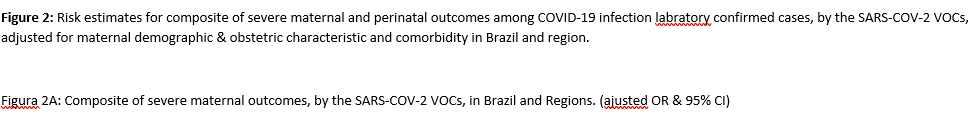

Logistic regression for Covid Variant (DELTA VS OMICROM) for each region

In [175]:
#lembrando que 1: gama, 2: delta e 3:omicrom

df_temp = df.loc[df['VARIANTE_COVID'] > 1].copy()  # Fazer uma cópia do subconjunto de dados
df_temp['EVOLUCAO'] = df_temp['EVOLUCAO'].replace({1: 2, 2: 1}) #cura = 2; obito = 1
df_temp.reset_index(inplace=True, drop=True)
df_temp['UTI_EVOLUCAO'] = df_temp['VARIANTE_COVID'] * 0

lista_obito = [2, 3]
for i in range(len(df_temp['VARIANTE_COVID'])):
    if (df_temp['EVOLUCAO'][i] in lista_obito) and (df_temp['UTI'][i] == 2):  # Indivíduos que não internaram na UTI e morreram
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 1
    if (df_temp['EVOLUCAO'][i] in lista_obito) and (df_temp['UTI'][i] == 1):  # Indivíduos que internaram na UTI e morreram
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 1
    if (df_temp['EVOLUCAO'][i] == 1) and (df_temp['UTI'][i] == 1):  # Indivíduos que internaram na UTI e não morreram
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 1
    if (df_temp['EVOLUCAO'][i] == 1) and (df_temp['UTI'][i] == 2):  # Indivíduos que não internaram na UTI e não morreram
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 0

# transformar 2 em 0

dic_covid = {2:1,3:0}
df_temp['VARIANTE_COVID']=df_temp['VARIANTE_COVID'].map(dic_covid) # true : delta, false : omicrom

#delimitar o dataset para cada região

df_temp_sudeste = df_temp.loc[df_temp['Regiao_nome'] == 'Sudeste']
df_temp_Sul = df_temp.loc[df_temp['Regiao_nome'] == 'Sul']
df_temp_Nordeste = df_temp.loc[df_temp['Regiao_nome'] == 'Nordeste']
df_temp_Centro_oeste = df_temp.loc[df_temp['Regiao_nome'] == 'Centro-oeste']
df_temp_Norte = df_temp.loc[df_temp['Regiao_nome'] == 'Norte']

region_list = ['Sudeste', 'Sul', 'Nordeste', 'Centro_oeste', 'Norte', 'Brasil']
data_list = [df_temp_sudeste, df_temp_Sul, df_temp_Nordeste, df_temp_Centro_oeste, df_temp_Norte, df_temp]
odds_ratios = []
lowerCI= []
upperCI = []

for region, data_ in zip(region_list, data_list):
   with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      model = smf.logit("VARIANTE_COVID ~ UTI_EVOLUCAO", data=data_).fit()
      #print()
      #print(f"Modelo para a região {region}:")
      #print()
      #print(model.summary())
      odds_ratios.append(np.exp(model.params[1]))
      lowerCI.append(np.exp(model.conf_int()[0][1]))
      upperCI.append(np.exp(model.conf_int()[1][1]))

or_ = pd.DataFrame({"OR": odds_ratios,"Lower CI": lowerCI,"Upper CI": upperCI})
or_.index = region_list
or_ = np.round(or_,2)
print()
display(or_)
print()
y = list(or_.index)
x = list(or_['OR'])

x_errormin = list(or_['Lower CI'])
x_errormax = list(or_['Upper CI'])

x_errormin = list(map(lambda x, y: x - y, x, x_errormin))
x_errormax = list(map(lambda x, y: x - y, x_errormax, x))

x_error = [x_errormin, x_errormax]

width = 0.2

plt.errorbar(x, y, xerr=x_error, fmt="ko")
plt.xlabel("Odds ratio")
plt.title('Associação entre Região e a infecção do SARS-CoV-2 (Delta VS Omicrom)')
plt.xlim(0,5)
plt.legend()
plt.show()

crosstab_delta_omicrom_REGIAO = pd.crosstab(df_temp['Regiao_nome'],df_temp['VARIANTE_COVID'])
crosstab_delta_omicrom_REGIAO.rename(columns = {0:"OMICROM", 1:"DELTA"} ,inplace = True)
print()
print("Número de casos das variantes para cada região:")
print(crosstab_delta_omicrom_REGIAO)

ValueError: zero-size array to reduction operation maximum which has no identity

Logistic regression for Covid Variant (GAMA VS OMICROM) for each region

In [176]:
#lembrando que 1: gama, 2: delta e 3:omicrom

df_temp = df.loc[df['VARIANTE_COVID'] != 2].copy()  # Fazer uma cópia do subconjunto de dados
df_temp['EVOLUCAO'] = df_temp['EVOLUCAO'].replace({1: 2, 2: 1}) #cura = 2; obito = 1
df_temp.reset_index(inplace=True, drop=True)
df_temp['UTI_EVOLUCAO'] = df_temp['VARIANTE_COVID'] * 0

lista_obito = [2, 3]
for i in range(len(df_temp['VARIANTE_COVID'])):
    if (df_temp['EVOLUCAO'][i] in lista_obito) and (df_temp['UTI'][i] == 2):  # Indivíduos que não internaram na UTI e morreram
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 1
    if (df_temp['EVOLUCAO'][i] in lista_obito) and (df_temp['UTI'][i] == 1):  # Indivíduos que internaram na UTI e morreram
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 1
    if (df_temp['EVOLUCAO'][i] == 1) and (df_temp['UTI'][i] == 1):  # Indivíduos que internaram na UTI e não morreram
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 1
    if (df_temp['EVOLUCAO'][i] == 1) and (df_temp['UTI'][i] == 2):  # Indivíduos que não internaram na UTI e não morreram
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 0

# transformar 3 em 0

dic_covid = {1:1,3:0}
df_temp['VARIANTE_COVID']=df_temp['VARIANTE_COVID'].map(dic_covid) # true : gama, false : omicrom

#delimitar o dataset para cada região

df_temp_sudeste = df_temp.loc[df_temp['Regiao_nome'] == 'Sudeste']
df_temp_Sul = df_temp.loc[df_temp['Regiao_nome'] == 'Sul']
df_temp_Nordeste = df_temp.loc[df_temp['Regiao_nome'] == 'Nordeste']
df_temp_Centro_oeste = df_temp.loc[df_temp['Regiao_nome'] == 'Centro-oeste']
df_temp_Norte = df_temp.loc[df_temp['Regiao_nome'] == 'Norte']

region_list = ['Sudeste', 'Sul', 'Nordeste', 'Centro_oeste', 'Norte', 'Brasil']
data_list = [df_temp_sudeste, df_temp_Sul, df_temp_Nordeste, df_temp_Centro_oeste, df_temp_Norte, df_temp]
odds_ratios = []
lowerCI= []
upperCI = []

for region, data_ in zip(region_list, data_list):
   with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      model = smf.logit("VARIANTE_COVID ~ UTI_EVOLUCAO", data=data_).fit()
      #print()
      #print(f"Modelo para a região {region}:")
      #print()
      #print(model.summary())
      odds_ratios.append(np.exp(model.params[1]))
      lowerCI.append(np.exp(model.conf_int()[0][1]))
      upperCI.append(np.exp(model.conf_int()[1][1]))

or_ = pd.DataFrame({"OR": odds_ratios,"Lower CI": lowerCI,"Upper CI": upperCI})
or_.index = region_list
or_ = np.round(or_,2)
print()
display(or_)
print()
y = list(or_.index)
x = list(or_['OR'])

x_errormin = list(or_['Lower CI'])
x_errormax = list(or_['Upper CI'])

x_errormin = list(map(lambda x, y: x - y, x, x_errormin))
x_errormax = list(map(lambda x, y: x - y, x_errormax, x))

x_error = [x_errormin, x_errormax]

width = 0.2

plt.errorbar(x, y, xerr=x_error, fmt="ko")
plt.xlabel("Odds ratio")
#plt.title('Associação entre Região e a infecção do SARS-CoV-2 (Delta VS Omicrom)')
plt.xlim(0,2.5)
plt.legend()
plt.show()

crosstab_gama_omicrom_REGIAO = pd.crosstab(df_temp['Regiao_nome'],df_temp['VARIANTE_COVID'])
crosstab_gama_omicrom_REGIAO.rename(columns = {0:"OMICROM", 1:"GAMA"} ,inplace = True)
print()
print("Número de casos das variantes para cada região:")
print(crosstab_gama_omicrom_REGIAO)

ValueError: zero-size array to reduction operation maximum which has no identity

Optimization terminated successfully.
         Current function value: 0.450310
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.527756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.442892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480149
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.473311
         Iterations 5



,OR,Lower CI,Upper CI
Sudeste,0.87,0.68,1.12
Sul,1.17,0.82,1.67
Nordeste,1.49,1.07,2.06
Centro_oeste,0.51,0.27,0.97
Norte,1.03,0.65,1.62
Brasil,0.99,0.85,1.16


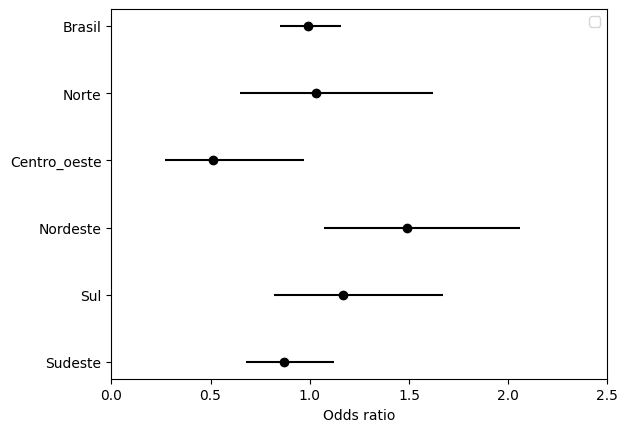


Número de casos das variantes para cada região:
VARIANTE_COVID  DELTA  GAMA
Regiao_nome                
Centro-oeste      202   876
Nordeste          235  1206
Norte             125   494
Sudeste           583  2916
Sul               324  1143


In [ ]:
#@title Regressão logística para Variante Covid (GAMA VS DELTA) para cada região
#lembrando que 1: gama, 2: delta e 3:omicrom

df_temp = df.loc[df['VARIANTE_COVID'] != 3].copy()  # Fazer uma cópia do subconjunto de dados
df_temp['EVOLUCAO'] = df_temp['EVOLUCAO'].replace({1: 2, 2: 1}) #cura = 2; obito = 1
df_temp.reset_index(inplace=True, drop=True)
df_temp['UTI_EVOLUCAO'] = df_temp['VARIANTE_COVID'] * 0

lista_obito = [2, 3]
for i in range(len(df_temp['VARIANTE_COVID'])):
    if (df_temp['EVOLUCAO'][i] in lista_obito) and (df_temp['UTI'][i] == 2):  # Indivíduos que não internaram na UTI e morreram
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 1
    if (df_temp['EVOLUCAO'][i] in lista_obito) and (df_temp['UTI'][i] == 1):  # Indivíduos que internaram na UTI e morreram
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 1
    if (df_temp['EVOLUCAO'][i] == 1) and (df_temp['UTI'][i] == 1):  # Indivíduos que internaram na UTI e não morreram
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 1
    if (df_temp['EVOLUCAO'][i] == 1) and (df_temp['UTI'][i] == 2):  # Indivíduos que não internaram na UTI e não morreram
        df_temp.loc[i, 'UTI_EVOLUCAO'] = 0

# transformar 2 em 0

dic_covid = {1:1,2:0}
df_temp['VARIANTE_COVID']=df_temp['VARIANTE_COVID'].map(dic_covid) # true : gama, false : delta

#delimitar o dataset para cada região

df_temp_sudeste = df_temp.loc[df_temp['Regiao_nome'] == 'Sudeste']
df_temp_Sul = df_temp.loc[df_temp['Regiao_nome'] == 'Sul']
df_temp_Nordeste = df_temp.loc[df_temp['Regiao_nome'] == 'Nordeste']
df_temp_Centro_oeste = df_temp.loc[df_temp['Regiao_nome'] == 'Centro-oeste']
df_temp_Norte = df_temp.loc[df_temp['Regiao_nome'] == 'Norte']

region_list = ['Sudeste', 'Sul', 'Nordeste', 'Centro_oeste', 'Norte', 'Brasil']
data_list = [df_temp_sudeste, df_temp_Sul, df_temp_Nordeste, df_temp_Centro_oeste, df_temp_Norte, df_temp]
odds_ratios = []
lowerCI= []
upperCI = []

for region, data_ in zip(region_list, data_list):
   with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      model = smf.logit("VARIANTE_COVID ~ UTI_EVOLUCAO", data=data_).fit()
      #print()
      #print(f"Modelo para a região {region}:")
      #print()
      #print(model.summary())
      odds_ratios.append(np.exp(model.params[1]))
      lowerCI.append(np.exp(model.conf_int()[0][1]))
      upperCI.append(np.exp(model.conf_int()[1][1]))

or_ = pd.DataFrame({"OR": odds_ratios,"Lower CI": lowerCI,"Upper CI": upperCI})
or_.index = region_list
or_ = np.round(or_,2)
print()
display(or_)
print()
y = list(or_.index)
x = list(or_['OR'])

x_errormin = list(or_['Lower CI'])
x_errormax = list(or_['Upper CI'])

x_errormin = list(map(lambda x, y: x - y, x, x_errormin))
x_errormax = list(map(lambda x, y: x - y, x_errormax, x))

x_error = [x_errormin, x_errormax]

width = 0.2

plt.errorbar(x, y, xerr=x_error, fmt="ko")
plt.xlabel("Odds ratio")
#plt.title('Associação entre Região e a infecção do SARS-CoV-2 (Delta VS Omicrom)')
plt.xlim(0,2.5)
plt.legend()
plt.show()

crosstab_gama_delta_REGIAO = pd.crosstab(df_temp['Regiao_nome'],df_temp['VARIANTE_COVID'])
crosstab_gama_delta_REGIAO.rename(columns = {0:"DELTA", 1:"GAMA"} ,inplace = True)
print()
print("Número de casos das variantes para cada região:")
print(crosstab_gama_delta_REGIAO)

**Table 3: Association of Clinical features of SARS-CoV-2 infection at admission and adverse maternal outcomes, by SARS-COV-2 VOCs,  in Brazil and regions.  (one table fo each outcome ICU admission, Intubation, maternal death).**

In [ ]:
#@title Regressão logística para UTI (ICU admission)
vars = ['FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'SATURACAO','DIARREIA', 'VOMITO', 'DOR_ABD', 'FADIGA', 'PERD_OLFT', 'PERD_PALA']
colunas = ['UTI', 'FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO', 'DOR_ABD', 'FADIGA', 'PERD_OLFT', 'PERD_PALA']

df_temp = df.copy()
for coluna in colunas:
    df_temp = df_temp.loc[df_temp[coluna] < 3]
df_temp['EVOLUCAO'] = df_temp['EVOLUCAO'].replace({1: 2, 2: 1}) #cura = 2; obito = 1
dic = {1:1, 2:0}
df_temp = df_temp.applymap(lambda x: dic.get(x, x))

selecao_gama = (df_temp['DT_COLETA'] >= '2021-03-01') & (df_temp['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df_temp['DT_COLETA'] >= '2021-09-01') & (df_temp['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df_temp['DT_COLETA'] >= '2022-01-01') & (df_temp['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df_temp[selecao_gama]
df_selecao_delta = df_temp[selecao_delta]
df_selecao_omicrom = df_temp[selecao_omicrom]

#criando modelo de Regressão Logística apenas para os p-values
models = {}
p_values = {}
for i, feature in enumerate(vars):
  with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        models[f"model_{i}"] = smf.logit(f"UTI ~ {feature}", data=df_temp).fit(disp=0)
        p_values[f"p_value_{i}"] = models[f"model_{i}"].pvalues[1]

lista_p_values = list(p_values.values())
lista_p_values = np.round(lista_p_values,4)

# Regressão Logística - Gama

odds_ratios_gama = []
lowerCI_gama= []
upperCI_gama = []

for i, var in enumerate(vars):
    formula = f"UTI ~ {var}"
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = smf.logit(formula, data=df_selecao_gama).fit(disp=0)

    odds_ratios_gama.append(np.exp(model.params[1]))
    lowerCI_gama.append(np.exp(model.conf_int()[0][1]))
    upperCI_gama.append(np.exp(model.conf_int()[1][1]))

or_gama = pd.DataFrame({"OR": odds_ratios_gama,"Lower CI": lowerCI_gama,"Upper CI": upperCI_gama})
or_gama.index = vars
or_gama = np.round(or_gama,2)
or_gama = or_gama.astype(str)
or_gama['OR GAMA (95% CI)'] = or_gama.apply(lambda x: x['OR'] + ' (' + x['Lower CI'] + ' ' + '-' + ' ' + x['Upper CI'] + ')', axis=1)
or_gama.drop(columns = ['OR','Lower CI','Upper CI'], inplace = True)

# Regressão Logística - Delta

odds_ratios_delta = []
lowerCI_delta= []
upperCI_delta = []

for i, var in enumerate(vars):
    formula = f"UTI ~ {var}"
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = smf.logit(formula, data=df_selecao_delta).fit(disp=0)

    odds_ratios_delta.append(np.exp(model.params[1]))
    lowerCI_delta.append(np.exp(model.conf_int()[0][1]))
    upperCI_delta.append(np.exp(model.conf_int()[1][1]))

or_delta = pd.DataFrame({"OR": odds_ratios_delta,"Lower CI": lowerCI_delta,"Upper CI": upperCI_delta})
or_delta.index = vars
or_delta = np.round(or_delta,2)
or_delta = or_delta.astype(str)
or_delta['OR DELTA (95% CI)'] = or_delta.apply(lambda x: x['OR'] + ' (' + x['Lower CI'] + ' ' + '-' + ' ' + x['Upper CI'] + ')', axis=1)
or_delta.drop(columns = ['OR','Lower CI','Upper CI'], inplace = True)

# Regressão Logística - Omicrom

odds_ratios_omicrom = []
lowerCI_omicrom = []
upperCI_omicrom = []

for i, var in enumerate(vars):
    formula = f"UTI ~ {var}"
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = smf.logit(formula, data=df_selecao_omicrom).fit(disp=0)

    odds_ratios_omicrom.append(np.exp(model.params[1]))
    lowerCI_omicrom.append(np.exp(model.conf_int()[0][1]))
    upperCI_omicrom.append(np.exp(model.conf_int()[1][1]))

or_omicrom = pd.DataFrame({"OR": odds_ratios_omicrom,"Lower CI": lowerCI_omicrom,"Upper CI": upperCI_omicrom})
or_omicrom.index = vars
or_omicrom = np.round(or_omicrom,2)
or_omicrom = or_omicrom.astype(str)
or_omicrom['OR OMICROM (95% CI)'] = or_omicrom.apply(lambda x: x['OR'] + ' (' + x['Lower CI'] + ' ' + '-' + ' ' + x['Upper CI'] + ')', axis=1)
or_omicrom.drop(columns = ['OR','Lower CI','Upper CI'], inplace = True)

or_UTI = pd.DataFrame({"OR GAMA (95% CI)":or_gama['OR GAMA (95% CI)'],"OR DELTA (95% CI)": or_delta['OR DELTA (95% CI)'],"OR OMICROM (95% CI)": or_omicrom['OR OMICROM (95% CI)']},index = vars)
or_UTI['p-value'] = list(lista_p_values)
or_UTI

,OR GAMA (95% CI),OR DELTA (95% CI),OR OMICROM (95% CI),p-value
FEBRE,1.25 (1.1 - 1.42),1.37 (1.04 - 1.8),1.63 (1.23 - 2.16),0.0000
TOSSE,1.35 (1.17 - 1.56),1.53 (1.12 - 2.1),1.2 (0.91 - 1.59),0.0000
GARGANTA,0.79 (0.67 - 0.93),0.95 (0.68 - 1.31),0.7 (0.5 - 0.99),0.0001
DISPNEIA,4.2 (3.58 - 4.93),4.71 (3.4 - 6.53),4.88 (3.67 - 6.5),0.0000
DESC_RESP,3.01 (2.63 - 3.45),3.26 (2.46 - 4.34),3.82 (2.87 - 5.08),0.0000
SATURACAO,4.03 (3.51 - 4.63),5.12 (3.82 - 6.87),6.23 (4.63 - 8.38),0.0000
DIARREIA,0.72 (0.57 - 0.89),0.81 (0.5 - 1.31),1.33 (0.73 - 2.44),0.3007
VOMITO,0.73 (0.58 - 0.91),1.02 (0.63 - 1.65),1.43 (0.91 - 2.27),0.2064
DOR_ABD,0.67 (0.53 - 0.86),1.0 (0.61 - 1.62),1.43 (0.91 - 2.27),0.0585
FADIGA,1.37 (1.2 - 1.57),1.74 (1.29 - 2.33),1.88 (1.35 - 2.62),0.0000


In [ ]:
#@title Regressão logística para Óbito
vars = ['FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'SATURACAO','DIARREIA', 'VOMITO', 'DOR_ABD', 'FADIGA', 'PERD_OLFT', 'PERD_PALA']

df_temp = df.loc[df['EVOLUCAO'] <4]

for coluna in vars:
    df_temp = df_temp.loc[df_temp[coluna] < 3]

dic_evolucao = {1:0, 2:1, 3:1} #Considerando cura : 0 e óbito : 1
dic = {1:1, 2:0}
df_temp['EVOLUCAO']=df_temp['EVOLUCAO'].map(dic_evolucao)

df_temp = df_temp.applymap(lambda x: dic.get(x, x))

selecao_gama = (df_temp['DT_COLETA'] >= '2021-03-01') & (df_temp['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df_temp['DT_COLETA'] >= '2021-09-01') & (df_temp['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df_temp['DT_COLETA'] >= '2022-01-01') & (df_temp['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df_temp[selecao_gama]
df_selecao_delta = df_temp[selecao_delta]
df_selecao_omicrom = df_temp[selecao_omicrom]

#criando modelo de Regressão Logística apenas para os p-values
models = {}
p_values = {}
for i, feature in enumerate(vars):
  with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        models[f"model_{i}"] = smf.logit(f"EVOLUCAO ~ {feature}", data=df_temp).fit(disp=0)
        p_values[f"p_value_{i}"] = models[f"model_{i}"].pvalues[1]

lista_p_values = list(p_values.values())
lista_p_values = np.round(lista_p_values,4)

# Regressão Logística - Gama

odds_ratios_gama = []
lowerCI_gama= []
upperCI_gama = []

for i, var in enumerate(vars):
    formula = f"EVOLUCAO ~ {var}"
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = smf.logit(formula, data=df_selecao_gama).fit(disp=0)

    odds_ratios_gama.append(np.exp(model.params[1]))
    lowerCI_gama.append(np.exp(model.conf_int()[0][1]))
    upperCI_gama.append(np.exp(model.conf_int()[1][1]))

or_gama = pd.DataFrame({"OR": odds_ratios_gama,"Lower CI": lowerCI_gama,"Upper CI": upperCI_gama})
or_gama.index = vars
or_gama = np.round(or_gama,2)
or_gama = or_gama.astype(str)
or_gama['OR GAMA (95% CI)'] = or_gama.apply(lambda x: x['OR'] + ' (' + x['Lower CI'] + ' ' + '-' + ' ' + x['Upper CI'] + ')', axis=1)
or_gama.drop(columns = ['OR','Lower CI','Upper CI'], inplace = True)

# Regressão Logística - Delta

odds_ratios_delta = []
lowerCI_delta= []
upperCI_delta = []

for i, var in enumerate(vars):
    formula = f"EVOLUCAO ~ {var}"
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = smf.logit(formula, data=df_selecao_delta).fit(disp=0)

    odds_ratios_delta.append(np.exp(model.params[1]))
    lowerCI_delta.append(np.exp(model.conf_int()[0][1]))
    upperCI_delta.append(np.exp(model.conf_int()[1][1]))

or_delta = pd.DataFrame({"OR": odds_ratios_delta,"Lower CI": lowerCI_delta,"Upper CI": upperCI_delta})
or_delta.index = vars
or_delta = np.round(or_delta,2)
or_delta = or_delta.astype(str)
or_delta['OR DELTA (95% CI)'] = or_delta.apply(lambda x: x['OR'] + ' (' + x['Lower CI'] + ' ' + '-' + ' ' + x['Upper CI'] + ')', axis=1)
or_delta.drop(columns = ['OR','Lower CI','Upper CI'], inplace = True)

# Regressão Logística - Omicrom

odds_ratios_omicrom = []
lowerCI_omicrom = []
upperCI_omicrom = []

for i, var in enumerate(vars):
    formula = f"EVOLUCAO ~ {var}"
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = smf.logit(formula, data=df_selecao_omicrom).fit(disp=0)

    odds_ratios_omicrom.append(np.exp(model.params[1]))
    lowerCI_omicrom.append(np.exp(model.conf_int()[0][1]))
    upperCI_omicrom.append(np.exp(model.conf_int()[1][1]))

or_omicrom = pd.DataFrame({"OR": odds_ratios_omicrom,"Lower CI": lowerCI_omicrom,"Upper CI": upperCI_omicrom})
or_omicrom.index = vars
or_omicrom = np.round(or_omicrom,2)
or_omicrom = or_omicrom.astype(str)
or_omicrom['OR OMICROM (95% CI)'] = or_omicrom.apply(lambda x: x['OR'] + ' (' + x['Lower CI'] + ' ' + '-' + ' ' + x['Upper CI'] + ')', axis=1)
or_omicrom.drop(columns = ['OR','Lower CI','Upper CI'], inplace = True)

or_OBITO = pd.DataFrame({"OR GAMA (95% CI)":or_gama['OR GAMA (95% CI)'],"OR DELTA (95% CI)": or_delta['OR DELTA (95% CI)'],"OR OMICROM (95% CI)": or_omicrom['OR OMICROM (95% CI)']},index = vars)
or_OBITO['p-value'] = list(lista_p_values)
or_OBITO

,OR GAMA (95% CI),OR DELTA (95% CI),OR OMICROM (95% CI),p-value
FEBRE,1.18 (1.0 - 1.4),1.17 (0.78 - 1.75),2.09 (1.37 - 3.2),0.0000
TOSSE,1.14 (0.94 - 1.38),1.25 (0.79 - 1.99),1.46 (0.94 - 2.27),0.0001
GARGANTA,1.07 (0.87 - 1.32),0.83 (0.51 - 1.36),0.45 (0.24 - 0.84),0.2341
DISPNEIA,3.75 (2.98 - 4.71),3.53 (2.13 - 5.85),11.53 (6.99 - 19.01),0.0000
DESC_RESP,2.85 (2.37 - 3.43),2.4 (1.58 - 3.66),6.76 (4.33 - 10.55),0.0000
SATURACAO,3.91 (3.22 - 4.75),4.19 (2.69 - 6.54),13.79 (8.67 - 21.95),0.0000
DIARREIA,0.85 (0.64 - 1.13),0.76 (0.36 - 1.62),3.31 (1.69 - 6.46),0.4382
VOMITO,0.84 (0.62 - 1.13),1.23 (0.63 - 2.41),1.57 (0.82 - 3.02),0.9696
DOR_ABD,0.84 (0.61 - 1.16),1.43 (0.74 - 2.73),1.58 (0.83 - 3.04),0.9918
FADIGA,1.02 (0.85 - 1.22),1.1 (0.71 - 1.71),1.78 (1.08 - 2.92),0.0077


**Considerações Finais**




*   Não há informações para realizar a regressão logística para a intubação (não encontrei a variável no dicionário de dados)
*   Não foram encontradas informações sobre Neonatal severe outcomes no dicionário de dados
*   Não há informações no dicionário de dados para construir a tabela 4
*   Não foram encontradas informações sobre Pregnancy outcomes no dicionário de dados







